## Init Directories

In [1]:
import os
def create_dirs() -> None:
    """
    Creates all required directories

    Parameters:
    None

    Returns:
    None
    """
    dirs_exist = False
    dir_dict = {
        "sd_flood": "output/flood",
        "sd_preflood": "output/preflood",
        "sd_flood_extents": "output/flood_extents",
        "sd_maxflood": "output/maxflood",
        "sd_csv": "output/csv",
        "sd_plots": "output/plots",
        "sd_shape": "output/shape",
        "sd_input": "input",
    }

    for k in dir_dict:
        if not os.path.exists(dir_dict[k]):
            os.makedirs(dir_dict[k])
        else:
            dirs_exist = True

    if dirs_exist:
        print("All directories exist")
    else:
        print("All directories created")

create_dirs()

All directories exist


# Config Cell
## [Jump to outputs](#Outputs)

In [2]:
# Add shapefile
shp = "input/LC_9C_TH.geojson"
buffer = 0 # boundary buffer
cell_size = 0.05 # grid cell size
# Set Error Folder ID from Google Drive
ERR_FOLDER_ID = None
# Set test_cells value if you need to test with initial 'n' cells instead of the entire grid
test_cells = 2
# Set run_checks to True if you want to run checks
run_checks = False
# Define main time period of analysis
timerange = ("2024-02", "2024-09")

### Load Dependencies

In [3]:
%matplotlib inline
!pip install fpdf
# load_dotenv()
# from dotenv import load_dotenv

import os, glob, warnings, datacube, rasterio, folium, json, io, statistics
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rio
import pandas as pd
from PIL import Image
from fpdf import FPDF
from rasterio.merge import merge
from rasterio.plot import show
from shapely.geometry import Point
from shapely.geometry import Polygon


from scipy.ndimage import uniform_filter
from scipy.ndimage import variance
from skimage.filters import threshold_minimum
from datacube.utils.geometry import Geometry

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.areaofinterest import define_area

from typing import Literal

from IPython.display import clear_output
from IPython.display import display

warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app="Radar_water_detection")

### Filter and Classifier Functions

In [5]:
# Function to apply lee filtering on S1 image. Speckle Filter
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    return img_output


# Classifier Function
def S1_water_classifier(da, threshold):
    water_data_array = da < threshold
    return water_data_array.to_dataset(name="s1_water")

### Operational Funtions

In [6]:
def gen_elog(e_log: list) -> list:
    """
    Writes a the error log json file and uploads it to the google drive folder ID, if specified.

    Parameters:
    e_log: list, required
        Error log list of [x, y, cell_id and None]. None will store the error "P" - Processing or "U" - Upload.

    Returns:
    e_log: list
        Error log list having the same values as the input parameter
    """
    e_log = np.array(e_log)
    with open("error_centroids.json", "w") as filehandle:
        json.dump(e_log.tolist(), filehandle)

    # read error log from disk
    with open("error_centroids.json") as f:
        e_log = json.load(f)
    for e in e_log:
        e[0] = float(e[0])
        e[1] = float(e[1])
        e[2] = int(e[2])

    if ERR_FOLDER_ID != None:
        try:
            gd.upload_files(["error_centroids.json"], ERR_FOLDER_ID, False)
        except Exception as e:
            print("FAILED TO UPLOAD ERROR LOG FILE REASON:{}".format(e))
    else:
        print("Error Log json created and stored on disc")

    return e_log

In [7]:
# Iterate through the input grid

th_aoi = []

def iterate_grid(aoi_m: list, c: list) -> list:
    """
    Iterates through every feature (cell) in the AOI grid.

    Parameters:
    aoi_m: list, required
        List of geojson feature collection (cells) that make up the entire grid.
    c: list, required
        List of [x, y, cell_id and None]. None will store the error "P" - Processing or "U" - Upload, if executio fails

    Returns:
    e_log: list
        Error log list of [x, y, cell_id and None]. None will store the error "P" - Processing or "U" - Upload.
    """
    e_log = []
    cell = 1

    # Run the main iterator
    for aoi, i in zip(aoi_m, c):
        geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
        geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)
        g = geopolygon_gdf.centroid

        # Add new page in the report
        report.add_page()
        # Cell description for the report
        disc = "GRID CELL ID {} NO. {}/{} CENTROID ({}, {})".format(
            i[2], cell, len(aoi_m), round(g.y[0], 5), round(g.x[0], 5)
        )
        report.multi_cell(0, 10, disc)

        print(
            "\n\n"
            + "\033[32m"
            + "PROCESSING GRID CELL ID {} NO. {}/{} CENTROID ({}, {})".format(
                i[2], cell, len(aoi_m), round(g.y[0], 5), round(g.x[0], 5)
            )
            + "\033[0m"
        )

        # Get the latitude and longitude range of the geopolygon
        lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
        lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

        # Load Sentinel1 data
        try:
            S1 = load_ard(
                dc=dc,
                products=["s1_rtc"],
                measurements=["vh"],
                y=lat_range,
                x=lon_range,
                time=timerange,
                output_crs="EPSG:6933",
                resolution=(-20, 20),
                group_by="solar_day",
                dtype="native",
            )
        except Exception as e:
            # Log error aoi centroids and keep looping
            e_log.append([g.x[0], g.y[0], i[2], "P"])

            # Error desc for report
            err_disc = "ERROR PROCESSING GRID CELL {}/{} CENTROID ({}, {}). LOGGED CENTROID INFO in e_log".format(
                i[2], len(aoi_m), round(g.y[0], 5), round(g.x[0], 5)
            )
            report.multi_cell(0, 10, err_disc)

            print(
                "\n\n"
                + "\033[31m"
                + "ERROR PROCESSING GRID CELL {}/{} CENTROID ({}, {}). LOGGED CENTROID INFO in e_log".format(
                    i[2], len(aoi_m), round(g.y[0], 5), round(g.x[0], 5)
                )
                + "\033[0m"
            )

            print("PROCESS ERROR: {}".format(e))
            cell += 1
            continue

        datasets = S1.time
        dn = len(datasets.time)
        print(dn)
        timesteps = [i for i in range(0, dn, 2)]
        timesteps

        # Plot datasets
        plt.figure()
        dataset = S1.vh.isel(time=timesteps)
        dataset_plot = dataset.plot(cmap="Greys_r", robust=True, col="time", col_wrap=5)
        plt.savefig("output/plots/cell_{}_dataset_plot.png".format(i[2]))
        plt.show()

        # The lee filter above doesn't handle null values
        # We therefore set null values to 0 before applying the filter
        valid = np.isfinite(S1)
        S1 = S1.where(valid, 0)

        # Create a new entry in dataset corresponding to filtered VV and VH data
        S1["filtered_vh"] = S1.vh.groupby("time").apply(lee_filter, size=7)

        # Null pixels should remain null
        S1["filtered_vh"] = S1.filtered_vh.where(valid.vh)

        # Convert the digital numbers to dB
        S1["filtered_vh"] = 10 * np.log10(S1.filtered_vh)

        threshold_vh = threshold_minimum(S1.filtered_vh.values)
        th_aoi.append(threshold_vh)
        print(threshold_vh)

        # Plot threshold
        plt.figure()
        fig, ax = plt.subplots(figsize=(15, 3))
        S1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
        plt.xlim(-40, -5)
        ax.axvspan(
            xmin=-40.0, xmax=threshold_vh, alpha=0.25, color="green", label="Water"
        )
        ax.axvspan(
            xmin=threshold_vh, xmax=-5, alpha=0.25, color="red", label="Not Water"
        )
        plt.legend()
        plt.xlabel("VH (dB)")
        plt.title("Effect of the classifier")

        plt.savefig("output/plots/cell_{}_th_plot.png".format(i[2]))
        plt.show()

        plt.close()

        # Add output plots and text to report
        report.multi_cell(0, 10, "Number of datasets: {}".format(dn))
        report.image("output/plots/cell_{}_dataset_plot.png".format(i[2]), w=180)
        report.multi_cell(0, 10, "Threshold: {}".format(threshold_vh))
        report.image("output/plots/cell_{}_th_plot.png".format(i[2]), w=180)

        cell += 1

    if len(e_log) == 0:
        print(
            "\n\n"
            + "\033[32m"
            + "GRID PROCESSED AND UPLOADED SUCCESSFULLY"
            + "\033[0m"
            + "\n\n"
        )

    e_log = gen_elog(e_log)

    # return e_log to be run again
    return e_log

In [8]:
# Crete the aoi-mosaic - aoi_m
def gen_aoim(c: list, b: float) -> list:
    """
    Generates the feature collection list (list of cells) using centroid coordinates and a buffer distance. Calls the main iterator for execution as well.

    Parameters:
    c: list, required
        List of [x, y, cell_id and None]. None will store the error "P" - Processing or "U" - Upload, if executio fails.
    b: float, required
        Cell half-dimension in degrees (EPSG:4326). Creates a cell by adding this distance to the centroid coordinates.

    Returns:
    e_log: list
        Error log list of [x, y, cell_id and None]. None will store the error "P" - Processing or "U" - Upload.
    """
    aoi_m = []
    for i in c:
        aoi_m.append(define_area(i[1], i[0], buffer=b))
    # print(c, len(aoi_m))
    e_log = iterate_grid(aoi_m, c)

    # return e_log to be run again
    return e_log

In [9]:
# Visualize input file
def view_input(gdf_list: list[gpd.GeoDataFrame], grid_c: list) -> None:
    """
    Visualizes cells and respective IDs  on a basemap.

    Parameters:
    gdf_list:list[gpd.GeoDataFrame], required
        List of geodataframes to be visualized.
    grid_c:list, required
        List of [x, y, cell_id and None]. None will store the error "P" - Processing or "U" - Upload, if executio fails.

    Returns:
    None

    """
    print("Visualizing data...")

    # Dissolve
    p = gdf_list[0].dissolve()
    center = p.centroid
    # map = folium.Map(location=[center.y, center.x], tiles="CartoDB Positron")
    map = folium.Map(location=[center.y, center.x])
    tile = folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Esri",
        name="Esri Satellite",
        overlay=False,
        control=True,
    ).add_to(map)

    for gdf in gdf_list:
        folium.GeoJson(gdf, name="{}".format(gdf)).add_to(map)

    for c in grid_c:
        folium.Marker(
            location=[c[1], c[0]],
            popup=f"Centroid: {c[1]}, {c[0]}",
            icon=folium.DivIcon(
                icon_size=(10, 10),
                icon_anchor=(0, 0),
                html='<div style="font-size: 10pt; color: #FFFFFF; text-shadow: 1.5px 1.5px 2px black">{}</div>'.format(
                    c[2]
                ),
            ),
        ).add_to(map)

    bounds = gdf_list[0].total_bounds.tolist()
    map.fit_bounds([bounds[:2][::-1], bounds[2:][::-1]])
 
    display(map)

In [10]:
# Create grid

def create_grid(adm0: gpd.GeoDataFrame, size: float) -> gpd.GeoDataFrame:
    """
    Divides adm0 AOI vectorfile into square grid based on size

    Parameters:
    adm0:gpd.GeoDataFrame, required
        AMD0 GeoDataFrame created from ADM0 input vector file
    size:float, required
        Grid cell size in degrees (EPSG:4326)

    Returns:
    grid: gpd.GeoDataFrame
        The generated grid GeoDataFrame
    """
    bounds = adm0.bounds
    minx = bounds.minx[0]  # only 1 feature at the 0th index
    miny = bounds.miny[0]
    maxx = bounds.maxx[0]
    maxy = bounds.maxy[0]

    grid = gpd.GeoDataFrame()
    for x0 in np.arange(minx, maxx, size):
        for y0 in np.arange(miny, maxy, size):
            x1 = x0 + size
            y1 = y0 + size
            d = {"geometry": [Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])]}
            cell = gpd.GeoDataFrame(d, crs="EPSG:4326")
            flag = adm0.intersection(cell)
            if flag[0].is_empty == False:
                grid = pd.concat([grid, cell])

    return grid

In [11]:
# Check CRS and convert to 4326 if required
def crs_check(shp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Checks input GeoDataFrame CRS and converts to EPSG 4326, if different.

    Parameters:
    shp: gpd.GeoDataFrame, required
        Input GeoDataFrame to check.

    Returns:
    shp: gpd.GeoDataFrame
        As is or converted GeoDataFrame.
    """
    if shp.crs != "EPSG:4326":
        print("Added ADM0 CRS is {}. Converting to EPSG:4326...".format(shp.crs))
        shp = shp.to_crs("EPSG:4326")
        if shp.crs == "EPSG:4326":
            print("Done")

    return shp

In [12]:
def check_inp(x: str) -> None:
    """
    Checks if input is "y" or "n"

    Parameters:
    x: str, required
        String input to be checked

    Returns:
    None
    """
    if x not in ["y", "n"]:
        raise ValueError("Invalid input, must be 'y' or 'n'")
    elif x == "n":
        raise RuntimeError(
            "Excecution terminated. Make necessary changes before running again"
        )


def exec_checks(c: list, buffer: float) -> None:
    """
    Performs checks and Run the entire application

    Parameters:
    c: list, required
        List of [x, y, cell_id and None]. None will store the error "P" - Processing or "U" - Upload, if executio fails.
    b: float, required
        Cell half-dimension in degrees (EPSG:4326). Creates a cell by adding this distance to the centroid coordinates.

    Returns:
    e_log: list
        Error log list of [x, y, cell_id and None]. None will store the error "P" - Processing or "U" - Upload.
    """

    inst = """
Before running the execution, ensure all requirements have been met:
1. Check input shapefile
3. Check grid size
    
    """
    print(inst)

    x = input("Input shapefile/geojson verified? (y/n):")
    check_inp(x)

    input("Grid (size) verified? (y/n):")
    check_inp(x)

    z = input("\nBegin threshold calculation for input shapefile/geojson? (y/n):")
    if z not in ["y", "n"]:
        raise ValueError("Invalid input, must be 'y' or 'n'")
    elif z == "n":
        raise RuntimeError(
            "Excecution terminated. Make necessary changes before running again"
        )
    elif z == "y":
        print("Starting execution...")
        # get e_log with centroids, cell_id and error message
        # Calling gen_aoim will run the entire Application
        e_log = gen_aoim(c, buffer)
        print(len(e_log))
        return e_log

In [13]:
def clean_dirs() -> None:
    """
    Creates directories if they dont exist or deletes residual files if they exist.

    Parameters:
    None

    Returns:
    None
    """
    dirs_exist = False
    dir_dict = {
        "sd_flood": "output/flood",
        "sd_preflood": "output/preflood",
        "sd_flood_extents": "output/flood_extents",
        "sd_maxflood": "output/maxflood",
    }

    for k in dir_dict:
        if not os.path.exists(dir_dict[k]):
            os.makedirs(dir_dict[k])
        else:
            dirs_exist = True
            r = del_files(dir_dict[k], "*")

    if dirs_exist:
        print("Output folders alredy exist.")
    else:
        print("Output folders created.")

    if not r:
        print("No residual files to delete.")

In [14]:
def del_files(path: str, ext: str) -> None:
    """
    Deletes all files with specified extention at specified folder path

    Parameters:
    path:str, required
        Folder path.
    ext:str, required
        File extension. "*" for all files.

    Returns:
    None
    """
    res_files = False
    loc = os.path.join(path, ext)
    files = glob.glob(loc)
    if len(files) > 0:
        res_files = True
        print("Found {} files. Deleting...".format(len(files)))
        for f in files:
            os.remove(f)

    return res_files

In [15]:
def create_shapefile(centroids, filename, preview=False):
    # Export grid polygon
    o_grid = gpd.GeoDataFrame()
    for i in centroids:
        point = Point(i[0], i[1])  # This takes x first and then y
        gdf = gpd.GeoDataFrame(geometry=[point])
        buffer = cell_size / 2
        cell = gpd.GeoDataFrame()
        cell["geometry"] = gdf.buffer(buffer, cap_style="square")
        cell.set_geometry("geometry")
        cell["cell_id"] = i[2]
        o_grid = pd.concat([o_grid, cell])

    o_grid = o_grid.set_crs("epsg:4326")
    o_grid.to_file("output/shape/{}_grid.geojson".format(filename), driver="GeoJSON")
    if preview:
        view_input([o_grid], centroids)

In [16]:
def add_adm(
    shp: str,
    boundary_buffer: float,
    cell_size: float,
    test_cells: int = None
) -> list | gpd.GeoDataFrame | pd.DataFrame:
    """
    Processes the input ADM file. File does not have to be ADM0 and can be any vectorfile.

    Parameters:
    shp: str, required
        Path of input vectorfile. Will be converted to EPSG:4326.
    boundary_buffer: float, required
        Outer boundary buffer to be given to the input vector file in degrees (EPSG:4326)
    cell_size: float, required
        Grid cell size in degrees (EPSG:4326)

    Returns:
    c: list
        List of [x, y, cell_id and None]. None will store the error "P" - Processing or "U" - Upload, if executio fails.
    grid: GeoDataFrame
        Grid file generated from input file
    adm_df: Dataframe
        Input file information
    """
    adm0_b = gpd.read_file(shp)  # adm0 base
    adm0_b = adm0_b.dissolve()
    adm0_buf = adm0_b.buffer(boundary_buffer)  # adm0 with 20KM boundary buffer
    adm0 = crs_check(adm0_buf)
    size = cell_size  # Grid cell size 0.5 ~ 55KM
    buffer = size / 2  # cell buffer around the centroid to create the cell

    grid = create_grid(adm0, size)
    # Calculate centroids and store in centroid list c[].
    c = []
    g = grid.centroid

    cell_id = 1
    for i in g:
        c.append(
            [round(i.x, 5), round(i.y, 5), cell_id, None]
        )  # The array c[] has four values: x, y, cell_id and None. None will store the "P" or "U" error value
        cell_id += 1

    n = len(c)
    
    if test_cells != None:
        c = c[:test_cells]
    else:
        test_cells = 0

    view_input([grid, adm0], c)

    adm_data = {
        "Parameter": [
            "Input File Path",
            "Area",
            "Area with Buffer",
            "Cell Size",
            "Total Cells",
            "Test Cells"
        ],
        "Value": [
            shp,
            "{} KM2".format(round((adm0_b.to_crs("EPSG:3857").area).iloc[0]/(10**6), 2)),
            "{} KM2".format(round((adm0.to_crs("EPSG:3857").area).iloc[0]/(10**6), 2)),
            "{} deg".format(cell_size),
            n,
            test_cells,
        ],
    }

    adm_df = pd.DataFrame(adm_data)
    adm_df.style.set_caption("Input Data")

    return (c, grid, adm_df)

# Outputs
## [Jump to config](#Config-Cell)

In [17]:
# Load file from sandbox disc. file should be present in 'input' folder
c, grid, adm_df = add_adm(shp, buffer, cell_size, test_cells)  # (shp, boundary_buffer, cell_size)
adm_df

Visualizing data...


Parameter                   Value
0   Input File Path  input/LC_9C_TH.geojson
1              Area             1147.47 KM2
2  Area with Buffer             1147.47 KM2
3         Cell Size                0.05 deg
4       Total Cells                      54
5        Test Cells                       2



PROCESSING GRID CELL ID 1 NO. 1/2 CENTROID (13.17537, 14.49848)
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 38 time steps
38


<Figure size 640x480 with 0 Axes>

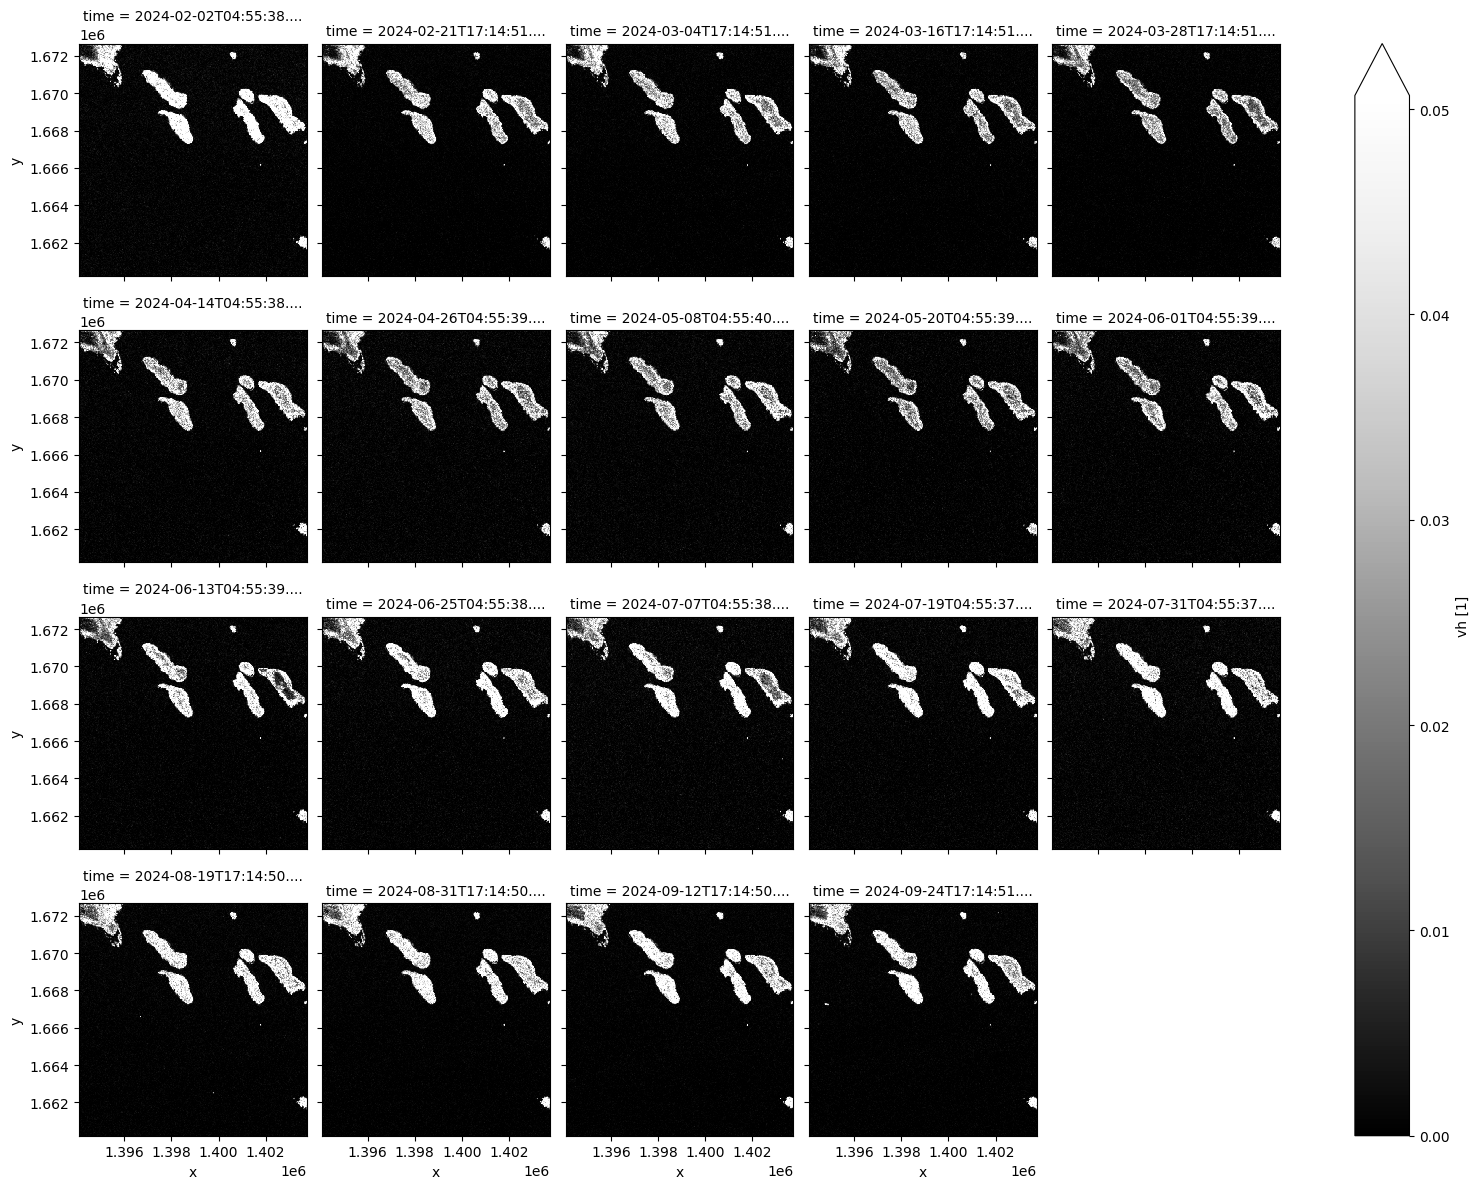

-20.597515


<Figure size 640x480 with 0 Axes>

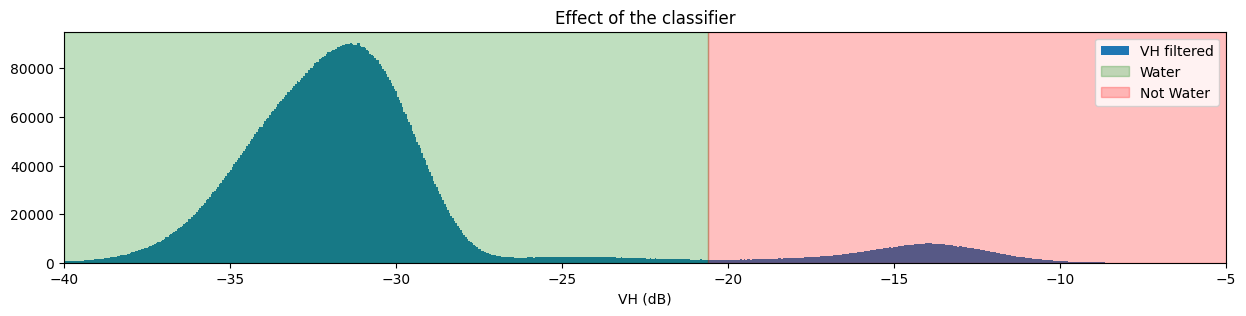



PROCESSING GRID CELL ID 2 NO. 2/2 CENTROID (13.22537, 14.49848)
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 38 time steps
38


<Figure size 640x480 with 0 Axes>

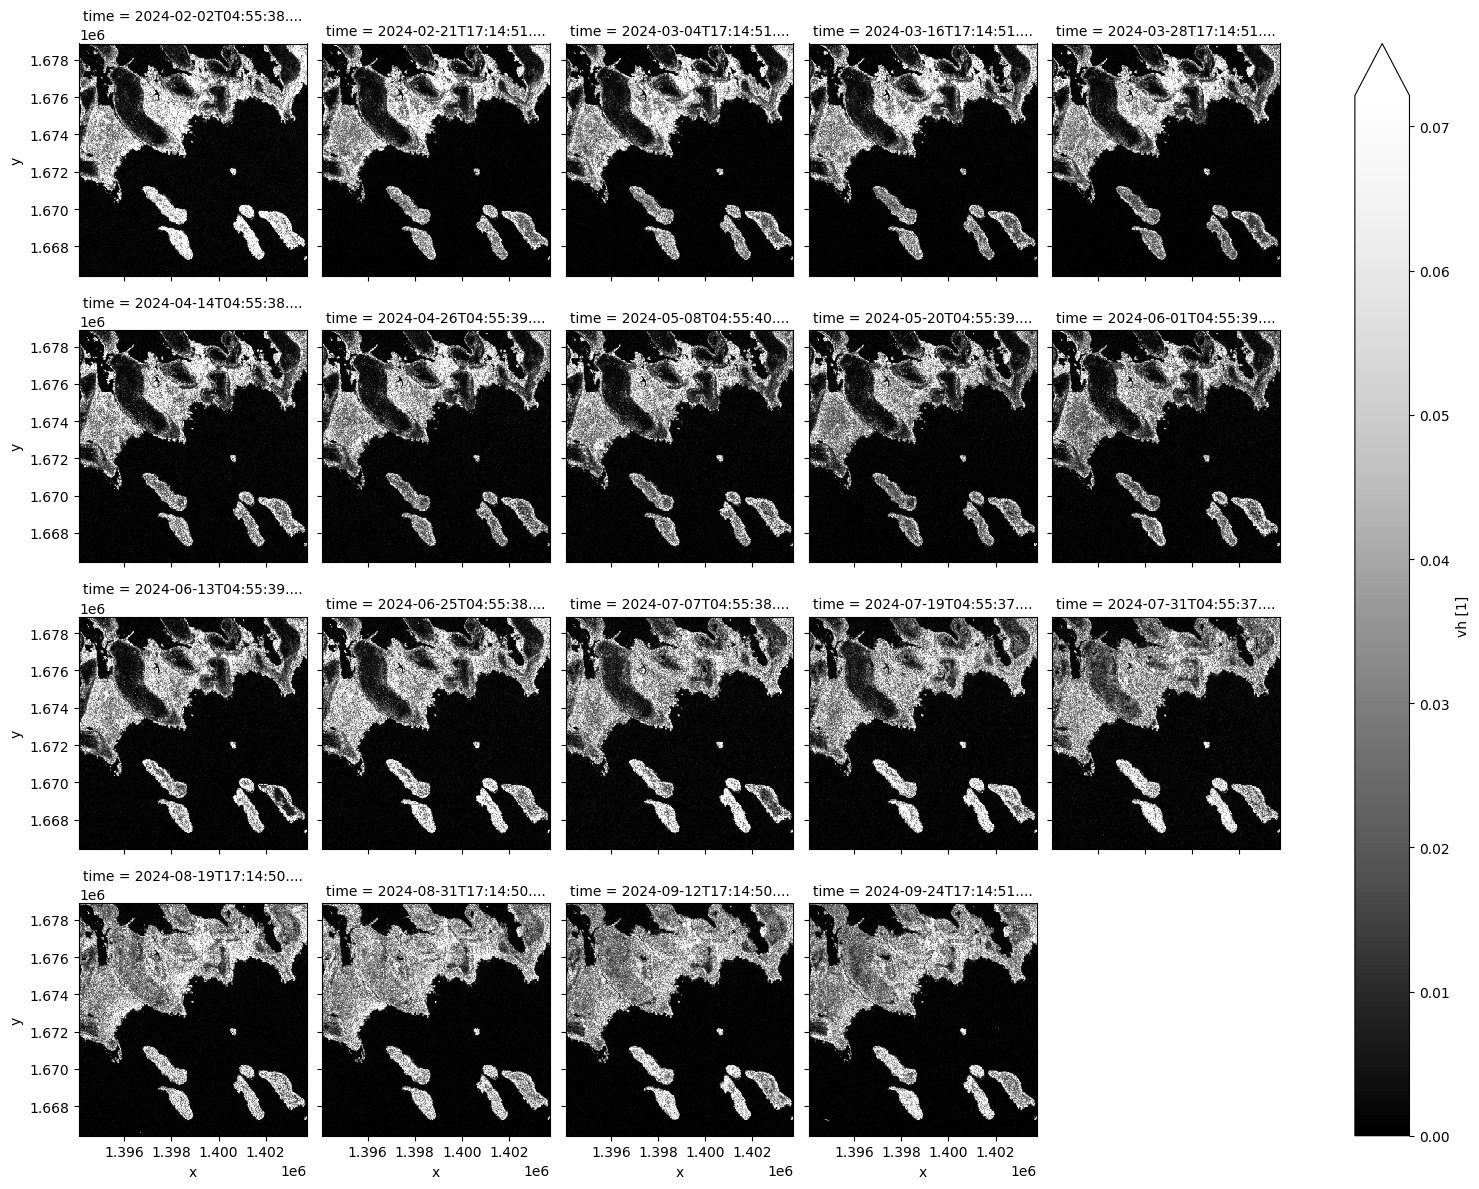

-22.734547


<Figure size 640x480 with 0 Axes>

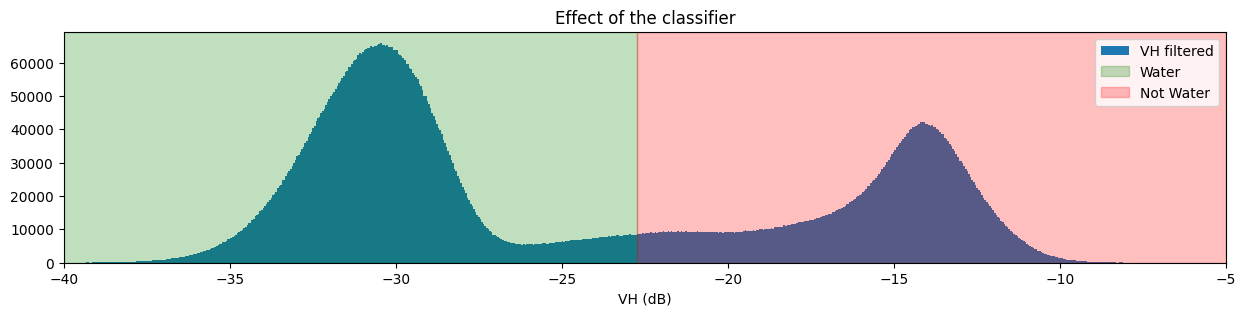



GRID PROCESSED AND UPLOADED SUCCESSFULLY


Error Log json created and stored on disc


In [18]:
# Calls the checklist function
report = FPDF()
report.set_font("Helvetica", size=9)
# Calls the checklist function
if run_checks:
    e_log = exec_checks(c, cell_size)
else:
    e_log = gen_aoim(c, cell_size)

In [19]:
th_mean = round(statistics.fmean(th_aoi), 6)
th_median = round(statistics.median(th_aoi), 6)

report.add_page()
report.multi_cell(0, 10, "Mean Threshold: {}".format(th_mean))
report.multi_cell(0, 10, "Median Threshold: {}".format(th_median))

report.output("output/plots/th_report.pdf")

''

In [20]:
e_log

[]

In [21]:
# Create processed and error shapefiles as grids in output/shape/
create_shapefile(c, "processed_file")
if len(e_log) > 0:
    create_shapefile(e_log, "error_file")

In [22]:
# Re-run application for cells logged in e_log, if required. Uncomment the following two lines and run
# if len(e_log) > 0:
#     e_log = gen_aoim(e_log, size / 2)